# Deep Gaussian Processes with Doubly Stochastic VI

In this notebook, we provide a GPyTorch implementation of deep Gaussian processes, where training and inference is performed using the method of Salimbeni et al., 2017 (https://arxiv.org/abs/1705.08933) adapted to CG-based inference.

We'll be training a simple two layer deep GP on the `elevators` UCI dataset.

In [1]:
%set_env CUDA_VISIBLE_DEVICES=1

import torch
import gpytorch
from torch.nn import Linear
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution, MeanFieldVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, AddedLossTerm, PredictiveLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood
from scipy.cluster.vq import kmeans2


env: CUDA_VISIBLE_DEVICES=1


In [2]:
from gpytorch.models.deep_gps import AbstractDeepGPLayer, AbstractDeepGP, DeepLikelihood
from gpytorch.models.deep_gps.predictive_deep_gp import AbstractPredictiveDeepGPLayer, AbstractDeepGP, DeepPredictiveGaussianLikelihood

## Loading Data

For this example notebook, we'll be using the `elevators` UCI dataset used in the paper. Running the next cell downloads a copy of the dataset that has already been scaled and normalized appropriately. For this notebook, we'll simply be splitting the data using the first 80% of the data as training and the last 20% as testing.

**Note**: Running the next cell will attempt to download a ~400 KB dataset file to the current directory.

In [3]:
import urllib.request
import os.path
from scipy.io import loadmat
from math import floor
import numpy as np

if not os.path.isfile('elevators.mat'):
    print('Downloading \'elevators\' UCI dataset...')
    urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1jhWL3YUHvXIaftia4qeAyDwVxo6j1alk', 'elevators.mat')
    
data = torch.Tensor(loadmat('elevators.mat')['data'])
X = data[:, :-1]
y = data[:, -1]

N = data.shape[0]
np.random.seed(0)
data = data[np.random.permutation(np.arange(N)),:]

train_n = int(floor(0.8*len(X)))

train_x = X[:train_n, :].contiguous().cuda()
train_y = y[:train_n].contiguous().cuda()

test_x = X[train_n:, :].contiguous().cuda()
test_y = y[train_n:].contiguous().cuda()

mean = train_x.mean(dim=-2, keepdim=True)
std = train_x.std(dim=-2, keepdim=True) + 1e-6
train_x = (train_x - mean) / std
test_x = (test_x - mean) / std

mean,std = train_y.mean(),train_y.std()
train_y = (train_y - mean) / std
test_y = (test_y - mean) / std

In [4]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x.cpu(), train_y.cpu())
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, pin_memory=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# Defining GP layers

In GPyTorch, defining a GP involves extending one of our abstract GP models and defining a `forward` method that returns the prior. For deep GPs, things are similar, but there are two abstract GP models that must be overwritten: one for hidden layers and one for the deep GP model itself.

In the next cell, we define an example deep GP hidden layer. This looks very similar to every other variational GP you might define. However, there are a few key differences:

1. Instead of extending `ApproximateGP`, we extend `AbstractDeepGPLayer`.
2. `AbstractDeepGPLayers` need a number of input dimensions, a number of output dimensions, and a number of samples. This is kind of like a linear layer in a standard neural network -- `input_dims` defines how many inputs this hidden layer will expect, and `output_dims` defines how many hidden GPs to create outputs for.

In [5]:
Q = 3

class ToyDeepGPHiddenLayer(AbstractPredictiveDeepGPLayer):
    def __init__(self, input_dims, output_dims, num_inducing=128, inducing_points=None, mean_type='constant'):
        if inducing_points is None:
            if output_dims is None:
                inducing_points = torch.randn(num_inducing, input_dims)
            else:
                inducing_points = torch.randn(output_dims, num_inducing, input_dims)

        variational_distribution = MeanFieldVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=torch.Size([output_dims]) if output_dims is not None else torch.Size([])
        )

        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )

        super(ToyDeepGPHiddenLayer, self).__init__(variational_strategy, input_dims, output_dims, Q)
        
        if mean_type == 'constant':
            self.mean_module = ConstantMean()
        else:
            self.mean_module = LinearMean(input_dims)
        self.covar_module = ScaleKernel(
            RBFKernel(batch_size=output_dims, ard_num_dims=input_dims),
            batch_size=output_dims, ard_num_dims=None
        )
        
        # self.linear_layer = Linear(input_dims, 1)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)
    
    def __call__(self, x, *other_inputs, **kwargs):
        """
        Overriding __call__ isn't strictly necessary, but it lets us add concatenation based skip connections
        easily. For example, hidden_layer2(hidden_layer1_outputs, inputs) will pass the concatenation of the first
        hidden layer's outputs and the input data to hidden_layer2.
        """
        if len(other_inputs):
            if isinstance(x, gpytorch.distributions.MultitaskMultivariateNormal):
                x = x.rsample()

            processed_inputs = [
                inp.unsqueeze(0).expand(self.num_samples, *inp.shape)
                for inp in other_inputs
            ]

            x = torch.cat([x] + processed_inputs, dim=-1)

        return super().__call__(x, are_samples=bool(len(other_inputs)))
    

# Building the model

Now that we've defined a class for our hidden layers and a class for our output layer, we can build our deep GP. To do this, we create a `Module` whose forward is simply responsible for forwarding through the various layers.

This also allows for various network connectivities easily. For example calling,
```
hidden_rep2 = self.second_hidden_layer(hidden_rep1, inputs)
```
in forward would cause the second hidden layer to use both the output of the first hidden layer and the input data as inputs, concatenating the two together.

In [6]:
class DeepGP(AbstractDeepGP):
    def __init__(self, train_x_shape, inducing_points):
        hidden_layer = ToyDeepGPHiddenLayer(
            input_dims=train_x_shape[-1],
            output_dims=3,
            mean_type='linear',
            inducing_points=inducing_points,
        )
        
        # second_layer_inds = hidden_layer(inducing_points.cpu())
        
        last_layer = ToyDeepGPHiddenLayer(
            input_dims=hidden_layer.output_dims,
            output_dims=None,
            mean_type='constant',
            inducing_points=None,  # No real initialization here.
        )
        
        super().__init__()
        
        self.hidden_layer = hidden_layer
        self.last_layer = last_layer
        self.likelihood = DeepPredictiveGaussianLikelihood(hidden_layer.output_dims, Q)
    
    def forward(self, inputs):
        hidden_rep1 = self.hidden_layer(inputs)
        output = self.last_layer(hidden_rep1)
        return output
    
    def predict(self, test_loader):
        with gpytorch.settings.fast_computations(log_prob=False, solves=False), torch.no_grad():
            mus = []
            variances = []
            lls = []
            for x_batch, y_batch in test_loader:
                preds = model.likelihood(model(x_batch))
                mus.append(preds.mean)
                variances.append(preds.variance)
                lls.append(model.likelihood.log_marginal(y_batch, model(x_batch)))
        
        return torch.cat(mus, dim=-1), torch.cat(variances, dim=-1), torch.cat(lls, dim=-1)

In [7]:
N_train = train_x.size(-2)
inducing_points = (train_x[torch.randperm(N_train)[0:128], :]).clone().data.cpu().numpy()
inducing_points = torch.tensor(kmeans2(train_x.cpu().numpy(), inducing_points, minit='matrix')[0]).cuda()

model = DeepGP(train_x.shape, inducing_points=inducing_points).cuda()

In [8]:
%load_ext snakeviz

# Likelihood

Because deep GPs use some amounts of internal sampling (even in the stochastic variational setting), we need to handle the likelihood in a slightly different way. In the future, we anticipate `DeepLikelihood` being a general wrapper around an arbitrary likelihood once likelihoods become a little more general purpose, but for now we simply define a `DeepGaussianLikelihood` to use for regression.

# Training the model

The training loop for a deep GP looks similar to a standard GP model with stochastic variational inference, but there are a few differences:

1. Because the output of a deep GP is actually num_outputs x num_samples Gaussians rather than a single Gaussian, we need to expand the labels to be num_outputs x num_samples x minibatch_size before calling the ELBO.
2. Because deep GPs involve a few added loss terms and normalize slightly differently, we created the `VariationalELBO` above with `combine_terms=False`. This just lets us do the extra normalization we need to make the math work out.

In [10]:
%%snakeviz

num_epochs = 2

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.01)
mll = PredictiveLogLikelihood(model.likelihood, model, train_x.shape[-2], beta=0.3)

import time

with gpytorch.settings.fast_computations(log_prob=False, solves=False):
    for i in range(num_epochs):
        for minibatch_i, (x_batch, y_batch) in enumerate(train_loader):
            x_batch = x_batch.cuda(async=True)
            y_batch = y_batch.cuda(async=True)
            start_time = time.time()
            optimizer.zero_grad()
            
            output = model(x_batch)
            loss = -mll(output, y_batch)
            print('Epoch %d [%d/%d] - Loss: %.3f - - Time: %.3f' % (i + 1, minibatch_i, len(train_loader), loss.item(), time.time() - start_time))

            loss.backward()
            optimizer.step()

Epoch 1 [0/13] - Loss: 0.639 - - Time: 0.044
Epoch 1 [1/13] - Loss: 0.650 - - Time: 0.043
Epoch 1 [2/13] - Loss: 0.617 - - Time: 0.041
Epoch 1 [3/13] - Loss: 0.646 - - Time: 0.039
Epoch 1 [4/13] - Loss: 0.646 - - Time: 0.042
Epoch 1 [5/13] - Loss: 0.638 - - Time: 0.040
Epoch 1 [6/13] - Loss: 0.647 - - Time: 0.047
Epoch 1 [7/13] - Loss: 0.627 - - Time: 0.049
Epoch 1 [8/13] - Loss: 0.647 - - Time: 0.040
Epoch 1 [9/13] - Loss: 0.613 - - Time: 0.042
Epoch 1 [10/13] - Loss: 0.665 - - Time: 0.042
Epoch 1 [11/13] - Loss: 0.610 - - Time: 0.039
Epoch 1 [12/13] - Loss: 0.596 - - Time: 0.048
Epoch 2 [0/13] - Loss: 0.611 - - Time: 0.039
Epoch 2 [1/13] - Loss: 0.611 - - Time: 0.039
Epoch 2 [2/13] - Loss: 0.627 - - Time: 0.040
Epoch 2 [3/13] - Loss: 0.559 - - Time: 0.040
Epoch 2 [4/13] - Loss: 0.601 - - Time: 0.041
Epoch 2 [5/13] - Loss: 0.595 - - Time: 0.040
Epoch 2 [6/13] - Loss: 0.604 - - Time: 0.043
Epoch 2 [7/13] - Loss: 0.604 - - Time: 0.041
Epoch 2 [8/13] - Loss: 0.587 - - Time: 0.039
Epoch 2

In [9]:
%debug

> c:\users\gardn\gpytorch\gpytorch\variational\variational_strategy.py(133)forward()
    131         predictive_mean = (
    132             torch.matmul(
--> 133                 induc_data_covar.transpose(-1, -2), mean_cache
    134             ).squeeze(-1)
    135             + test_mean

ipdb> q]


# Make predictions and get an RMSE

The output distribution of a deep GP in this framework is actually a mixture of `num_samples` Gaussians for each output. We get predictions the same way with all GPyTorch models, but we do currently need to do some reshaping to get the means and variances in a reasonable form.

SVGP gets an RMSE of around 0.41 after 60 epochs of training, so overall getting an RMSE of 0.35 out of a 2 layer deep GP without much tuning involved is pretty good!

In [9]:
import gpytorch
import math

model.eval()
predictive_means, predictive_variances, lls = model.predict(test_loader)

# rmse = torch.mean(torch.pow(predictive_means.mean(0) - test_y, 2)).sqrt()
# print(rmse)
# print(lls.mean())

In [10]:
print(lls.mean())
print(lls[lls < -10])

tensor(-0.2605, device='cuda:0')
tensor([], device='cuda:0')


In [48]:
# print(model.likelihood.quad_weight_grid.exp().sum())
# print(predictive_means * model.likelihood.quad_weight_grid.unsqueeze(-1))

In [11]:
# def wa(vec):
#     return (vec * model.likelihood.quad_weight_grid.unsqueeze(-1).exp()).sum(0)

# denom = (wa(predictive_variances) + wa(predictive_means.pow(2)) - wa(predictive_means)**2)
# num = wa(predictive_variances)

# print((num / denom).median())

In [16]:
import math

print(model.likelihood.quad_weight_grid.exp())
print(model.last_layer.xi)
print(model.hidden_layer.covar_module.outputscale)
print(model.last_layer.covar_module.outputscale)

tensor([4.7913e-04, 3.4258e-03, 1.4641e-03, 1.9968e-03, 2.2324e-02, 6.9754e-03,
        4.3713e-04, 3.7911e-03, 2.3742e-03, 1.1122e-02, 5.2905e-02, 3.2957e-03,
        4.7070e-02, 6.0626e-01, 2.1441e-02, 6.3259e-03, 2.7230e-02, 7.5229e-03,
        2.0902e-03, 1.2357e-02, 3.2707e-03, 7.9717e-03, 1.0222e-01, 1.6643e-02,
        2.0352e-03, 1.9187e-02, 7.7753e-03], device='cuda:0',
       grad_fn=<ExpBackward>)
Parameter containing:
tensor([[-0.2055,  0.0072, -0.2566],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.2055, -0.0072,  0.2566]], device='cuda:0', requires_grad=True)
tensor([1.3042, 0.7378, 1.0749], device='cuda:0', grad_fn=<SoftplusBackward>)
tensor(1.1685, device='cuda:0', grad_fn=<SoftplusBackward>)


In [13]:
sq_errors = torch.pow((predictive_means * model.likelihood.quad_weight_grid.unsqueeze(-1).exp()).sum(0) - test_y, 2)
# sq_errors = torch.pow(predictive_means.mean(0) - test_y, 2)
print(sq_errors.mean().sqrt())

tensor(0.3487, device='cuda:0', grad_fn=<SqrtBackward>)


(-2, 1.0)

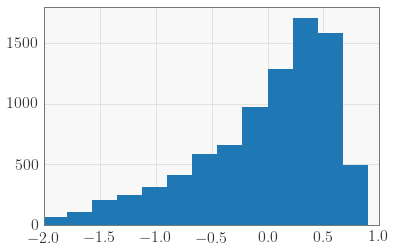

In [111]:
plt.hist(lls[sq_errors <1.].cpu(), bins=40)
plt.xlim([-2, 1.])

In [14]:
mus = []
sigmas = []
for x_batch, y_batch in test_loader:
    preds = model.likelihood(model(x_batch))
    mus.append(preds.mean)
    sigmas.append(preds.variance.sqrt())

mus = torch.cat(mus, -1)
sigmas = torch.cat(sigmas, -1)

In [15]:
rmse = torch.mean(torch.pow(mus.mean(0) - test_y, 2)).sqrt()
test_lls = torch.distributions.Normal(mus, sigmas).log_prob(test_y).logsumexp(0) - math.log(predictive_means.size(0))

torch.Size([27, 3320])

In [14]:
torch.cuda.empty_cache()